## Linear Regression with HOG Features

This notebook contains our linear regression model for price prediction on the Bikes dataset.

We generate histogram of oriented gradients (HOG) features using the VGG-16 network, and reduce their dimensionality using PCA.

We then train linear regression on the training set, and report evaluation metrics on the test set.

### Imports

In [4]:
from sklearn.decomposition import PCA

import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import tensorflow as tf
import csv

from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

### Extract and Save Features

We run the dataset through VGG-16, extracting the activations of the last feature layer as our high-dimensional feature vectors. We then reduce the dimensionality using PCA.

In [5]:
im_inds = []
im_names = []
im_prices = np.zeros(21843)
with open('../datasets/bikes_filtered.csv', 'r') as f:
        datareader = csv.reader(f)
        for i, line in enumerate(datareader):
            im_inds.append(line[0])
            im_names.append(line[1])
            im_prices[i] = int(line[2])

In [ ]:
from skimage.feature import hog

for i in range(0, len(im_inds)):
    #print(i)
    im_ind = im_inds[i]
    image_file = '../datasets/bikes_im/' + str(im_ind) + '.jpg'
    curr_im = color.rgb2gray(imread(image_file))
    resized_im = resize(curr_im, (224,224))
    images.append(resized_im)
    
    if i % 1000 == 0:
        print(i)

hog_array = np.zeros((len(images), 224*224))
print("hogarray")
print(hog_array)

for i, image in enumerate(images):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(32, 32),
                        cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')
    flattened_len = int(hog_image.shape[0]) * int(hog_image.shape[1])
    pixels = np.reshape(hog_image, (-1, flattened_len))
    hog_array[i, :] = pixels
    
    if i % 1000 == 0:
        print(i)

pca = PCA(n_components=2)
pca.fit(hog_array)
hog_images_compressed = pca.transform(hog_array)
print(hog_images_compressed)

pca = PCA(n_components=200)
pca.fit(hog_array)
hog_images_compressed = pca.transform(hog_array)

np.save("linreg_hog_pca_features", hog_images_compressed)
np.save("linreg_hog_pca_components", pca.components_)

### Linear Regression using HOG Features

We train linear regression on the PCA-processed HOG features on our training split, then evaluate on the test split.

We report three different metrics: MSE (mean squared error), MAE (mean absolute error), and R^2 (coefficient of determination)

In [7]:
# Load training and eval data
cnn_feats_compressed = np.load("linreg_hog_pca_features.npy")

train_inds = np.load('bikes_train_indices.npy')
test_inds = np.load('bikes_test_indices.npy')

train_data = cnn_feats_compressed[train_inds]
train_labels = im_prices[train_inds]

test_data = cnn_feats_compressed[test_inds]
test_labels = im_prices[test_inds]


regr = linear_model.LinearRegression()

regr.fit(train_data, train_labels)

predicted = regr.predict(test_data)

# Metrics
MSE = mean_squared_error(test_labels, predicted)
MAE = mean_absolute_error(test_labels, predicted)
R2 = r2_score(test_labels, predicted)

print("Mean squared error: %.2f" % MSE)
print("Mean absolute error: %.2f" % MAE)
print('Coefficient of determination: %.2f' % R2)

Mean squared error: 1625602.51
Mean absolute error: 833.02
Coefficient of determination: 0.50


In [8]:
error = []
for a,b in zip(test_labels, predicted):
    error.append((np.absolute(a-b),a,b))
error.sort(key=lambda x: x[0])

error_x = range(len(error))
error_val = []
error_y_label = []
error_y_pred = []
for e in error:
    error_val.append(e[0])
    error_y_label.append(e[1])
    error_y_pred.append(e[2])

Text(0,0.5,'Absolute Error')

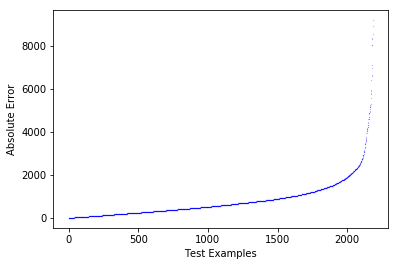

In [10]:
plt.scatter(error_x, error_val,  color='blue', s=0.01)
plt.xlabel('Test Examples')
plt.ylabel('Absolute Error')